In [1]:
from itertools import product

import numpy as np
import pandas as pd
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, 
    average_precision_score, precision_recall_curve, f1_score
)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean, f2s
from doe_modules.ml import plot_pr, plot_roc
from doe_modules.simulation import BenchmarkingPipeline, Test9

from doe_modules.simulation.esm9_metrics import *

In [2]:
top10 = np.array([
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "edge_effectivity",
    "mean_factor_density",
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "max_cascade_length_ratio",
    "effective_edge_positivity"
])

negs = [
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "effective_edge_positivity"
]

key_features = [
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "effective_edge_positivity"
]

In [3]:
from tqdm.notebook import tqdm

edges = np.load(f"{outputdir}/esm_test9_edges.npy")

n = (lambda arr: (-1 + np.sqrt(1 + 8 * arr.size)) / 2)(edges[0])
ppc = np.fromiter(map(positive_pathway_coverage, edges), float).reshape(-1, 1)
maxped = np.fromiter(map(lambda arr: 1 - max_positive_edge_density(arr), edges), float).reshape(-1, 1)
maxsed = np.fromiter(map(lambda arr: 1 - max_synergetic_edge_density(arr), edges), float).reshape(-1, 1)
meanped = np.fromiter(map(lambda arr: 1 - mean_positive_edge_density(arr), edges), float).reshape(-1, 1)
pc = np.fromiter(map(pathway_coverage, edges), float).reshape(-1, 1)
eep = np.fromiter(map(lambda arr: 1 - effective_edge_positivity(arr), edges), float).reshape(-1, 1)

full = np.hstack([ppc, maxped, maxsed, meanped, pc, eep])


df = pd.concat(
    [
        pd.read_feather(f"{outputdir}/esm_test9.feather"),
        pd.DataFrame(
            full,
            columns=key_features
        ),
        pd.DataFrame({
            f"arithmetic{i + 1}": mat.mean(axis=1) for i, mat in tqdm(enumerate(
                [
                    full[:, np.where(arr_bool)[0]] for arr_bool in map(
                        lambda lst_bool: np.array(lst_bool), 
                        product(*[[True, False]] * 6)
                    ) if arr_bool.sum() > 1
                ]
            ))
        })
    ],
    axis=1
)

df = df.assign(
    better_with_pb=df.pb > df.cloo
)

0it [00:00, ?it/s]

In [4]:
df

,cloo,pb,v,,positive_pathway_coverage,max_positive_edge_density,max_synergetic_edge_density,mean_positive_edge_density,pathway_coverage,effective_edge_positivity,...,arithmetic49,arithmetic50,arithmetic51,arithmetic52,arithmetic53,arithmetic54,arithmetic55,arithmetic56,arithmetic57,better_with_pb
0,0.666667,0.526316,1,C+LOO,0.222222,0.583333,0.583333,0.891667,0.666667,0.583333,...,0.686111,0.737500,0.611111,0.625000,0.583333,0.713889,0.779167,0.737500,0.625000,False
1,1.000000,0.181818,1,C+LOO,0.111111,0.705882,0.705882,0.958333,0.555556,0.647059,...,0.770425,0.832108,0.636166,0.630719,0.676471,0.720316,0.756944,0.802696,0.601307,False
2,0.000000,0.526316,0,neither,0.333333,0.761905,0.285714,0.933333,0.666667,0.285714,...,0.501587,0.609524,0.412698,0.476190,0.285714,0.628571,0.800000,0.609524,0.476190,True
3,0.307692,0.674699,2,PB,0.333333,0.800000,0.800000,0.958333,0.777778,0.700000,...,0.819444,0.879167,0.759259,0.788889,0.750000,0.812037,0.868056,0.829167,0.738889,True
4,0.000000,0.457831,0,neither,0.111111,0.875000,0.687500,0.983333,0.555556,0.437500,...,0.702778,0.835417,0.560185,0.621528,0.562500,0.658796,0.769444,0.710417,0.496528,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.240964,0.780488,2,PB,0.222222,0.782609,0.782609,0.925000,0.666667,0.565217,...,0.757609,0.853804,0.671498,0.724638,0.673913,0.718961,0.795833,0.745109,0.615942,True
19996,0.000000,0.000000,0,neither,0.222222,0.956522,0.478261,0.991667,0.777778,0.347826,...,0.605918,0.734964,0.534622,0.628019,0.413043,0.705757,0.884722,0.669746,0.562802,False
19997,0.156250,0.228571,0,neither,0.444444,0.681818,0.500000,0.925000,0.777778,0.454545,...,0.626515,0.712500,0.577441,0.638889,0.477273,0.719108,0.851389,0.689773,0.616162,True
19998,0.357143,0.000000,0,neither,0.444444,0.678571,0.678571,0.841667,0.888889,0.392857,...,0.637698,0.760119,0.653439,0.783730,0.535714,0.707804,0.865278,0.617262,0.640873,False


from sklearn.metrics import confusion_matrix

In [5]:
import seaborn as sns

In [6]:
def div22():
    weight = np.array([1 / n, 1 - (1 / n)])
    val = np.hstack([
        ppc, 
        maxped
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div3():
    weight = np.array([1, n, (n + 1) * (n - 1), 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div1234():
    weight = np.array([1, n, n ** 2, 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div123():
    weight = np.array([1, n, n ** 2])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div234():
    weight = np.array([n, n ** 2, 1])
    val = np.hstack([
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div23():
    weight = np.array([n, n ** 2])
    val = np.hstack([
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()

In [7]:
# df = pd.concat(
#     [
#         df, 
#         pd.DataFrame(dict(
#             div22=div22(),
#             div3=div3(),
#             div1234=div1234(),
#             div123=div123(),
#             div234=div234(),
#             div23=div23()
#         ))
#     ],
#     axis=1
# )

[Text(0.5, 0, 'false positive rate'), Text(0, 0.5, 'true positive rate')]

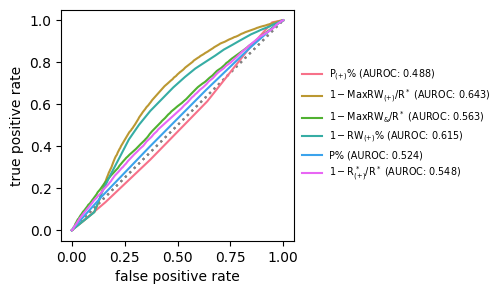

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [df.loc[:, v] for v in key_features]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in key_features
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), frameon=False)
ax.set(xlabel="false positive rate", ylabel="true positive rate")

# fig.savefig(f"{outputdir}/test9_roc", **kwarg_savefig)

<Axes: xlabel='AUROC'>

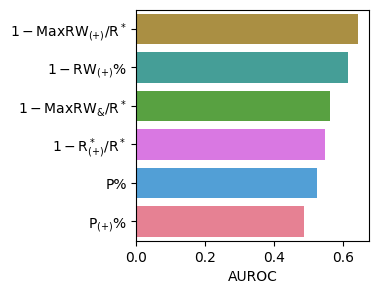

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [df.loc[:, v] for v in key_features]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in key_features
]

cmap = sns.color_palette("husl", len(features))

df_bar = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": cmap
}, index=key_features).sort_values("AUROC", ascending=False)

sns.barplot(
    data=df_bar,
    x="AUROC", y="", hue="",
    palette=df_bar.cmap.tolist()
)

# fig.savefig(f"{outputdir}/test9_auc", **kwarg_savefig)

[Text(0.5, 1.0, 'ESM9'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

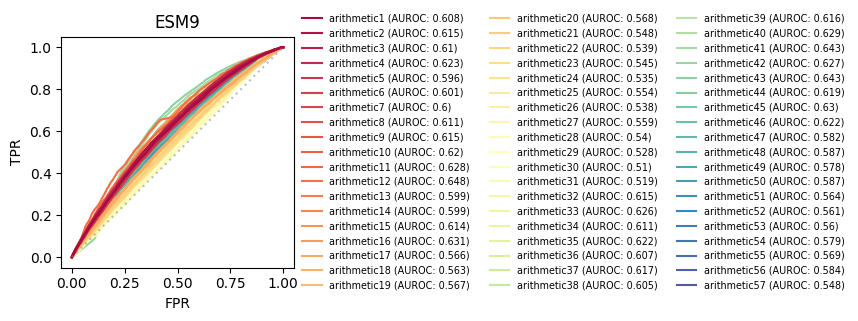

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    eval("df.arithmetic" + f"{i + 1}") for i in range(57)
]

names = [
    f"arithmetic{i + 1}" for i in range(57)
]


cmap = sns.color_palette("Spectral", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i],
        zorder=-i
    )

ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), ncol=3, frameon=False)
ax.set(title="ESM9", xlabel="FPR", ylabel="TPR")

# fig.savefig(f"{outputdir}/test9_roc_arithmetic", **kwarg_savefig)

[Text(0.5, 1.0, 'ESM9')]

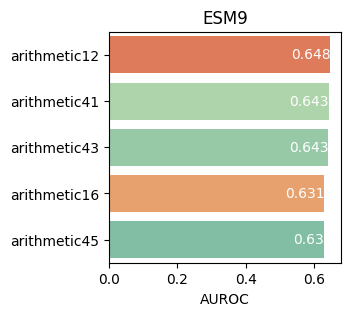

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    eval("df.arithmetic" + f"{i + 1}") for i in range(57)
]

names = [
    f"arithmetic{i + 1}" for i in range(57)
]

df_bar_arith = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": sns.color_palette("Spectral", len(features))
}, index=names).sort_values("AUROC", ascending=False).iloc[:5, :]

sns.barplot(
    data=df_bar_arith,
    x="AUROC", y="", hue="",
    palette=df_bar_arith.cmap.tolist()
)

for i, auroc in enumerate(df_bar_arith.AUROC):
    ax.text(
        auroc, i, round(auroc, 3), 
        ha="right", va="center", color="w"
    )

ax.set(title="ESM9")

# fig.savefig(f"{outputdir}/test9_auc_arithmetic", **kwarg_savefig)

In [12]:
from sklearn.model_selection import StratifiedKFold, train_test_split

from scipy.interpolate import interp1d
from scipy.stats import bootstrap

from doe_modules.preferences import kwarg_bootstrap

In [13]:
def roc_integration(
    data, key
):
    data_key = data.loc[data.feat_names == key, ["x", "y", "folds"]]
    return pd.DataFrame({
        "feat_names": [key] * data_key.x.unique().size,
        "x": np.sort(data_key.x.unique()), 
        **{
            f"fold_{i}": interp1d(
                np.sort(data_key.x[data_key.folds == i].values),
                data_key.y[data_key.folds == i].values[
                np.argsort(data_key.x[data_key.folds == i].values)
                ]
            )(np.sort(data_key.x.unique())) for i in data_key.folds.unique()
        },
    })


def roc_multimetric_integration(data):
    return pd.concat(
        [roc_integration(data, key) for key in data.feat_names.unique()],
        axis=0
    )

In [14]:
arr_condition = np.vstack([
    arr_bool for arr_bool in map(
        lambda lst_bool: np.array(lst_bool), 
        product(*[[True, False]] * 6)
    ) if arr_bool.sum() > 1
])

In [15]:
xs, ys = np.array([]), np.array([])
feat_names = []
folds = []

metrics = [
    f"arithmetic{i + 1}" for i in range(len(arr_condition))
]
aurocs = {key: [] for key in metrics}

for i, (_, te) in enumerate(
    StratifiedKFold(
        n_splits=30, shuffle=True, random_state=0
    ).split(df[metrics], df.better_with_pb)
):
    x_te, y_te = df[metrics].loc[te, :], df.better_with_pb[te]

    for key in metrics:
        x, y = roc_curve(y_te, x_te[key])[:2]
        xs, ys = np.hstack([xs, x]), np.hstack([ys, y])
        feat_names += [key] * x.size
        folds += [i] * x.size
        aurocs[key] += [roc_auc_score(y_te, x_te[key])]


df_roc = pd.DataFrame({
    "x": xs, "y": ys, "feat_names": feat_names, "folds": folds
})

aurocs_ci = {
    k: bootstrap(
        (v,), **kwarg_bootstrap
    ).confidence_interval for k, v in aurocs.items()
}

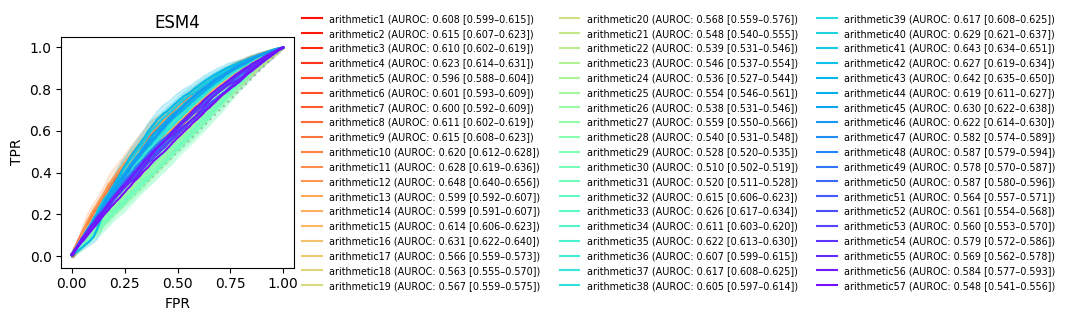

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.subplots_adjust(wspace=.55)

df_roc_integrated = roc_multimetric_integration(df_roc)
fixed_cmap = {
    # **fixed_cmap, 
    **{
        f"arithmetic{i + 1}": c for i, c in enumerate(
            sns.color_palette("rainbow_r", len(arr_condition))
        )
    }
}

# sorted_feat_names = pd.DataFrame(aurocs).mean().sort_values(ascending=False).index
# sorted_cmap = pd.Series(
#     [i for i in range(len(metrics))], index=metrics
# )[sorted_feat_names].apply(lambda i: cmap[i]).tolist()
df_auroc = pd.DataFrame({
    "AUROC": np.array([aurocs[k] for k in metrics]).ravel(),
    "feat_names": np.array([[k] * len(aurocs[k]) for k in metrics]).ravel(),
    "": np.array([[k.split("arithmetic")[-1]] * len(aurocs[k]) for k in metrics]).ravel()
})


df_mean_auroc = df_auroc.loc[
    :, ["feat_names", "AUROC"]
].groupby("feat_names").mean().loc[metrics]


for i, key in enumerate(metrics):
    df_roc_sep = df_roc_integrated.loc[
        df_roc_integrated.feat_names == key, :
    ]
    low, high = aurocs_ci[key].low, aurocs_ci[key].high
    ax.plot(
        df_roc_sep.x,
        df_roc_sep.iloc[:, 2:].mean(axis=1),
        c=fixed_cmap[metrics[i]],
        label=metrics[i] + f" (AUROC: {f2s(df_mean_auroc.loc[key].item())} [{f2s(low)}–{f2s(high)}])", 
    )
    ax.fill_between(
        df_roc_sep.x, 
        df_roc_sep.iloc[:, 2:].mean(axis=1) - df_roc_sep.iloc[:, 2:].std(axis=1),
        df_roc_sep.iloc[:, 2:].mean(axis=1) + df_roc_sep.iloc[:, 2:].std(axis=1),
        color=fixed_cmap[metrics[i]], alpha=.2, zorder=-(i + 1) * 10
    )

ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax.set(title="ESM4", xlabel="FPR", ylabel="TPR")
ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), ncol=3, frameon=False)

# fig.savefig(f"{outputdir}/test9_roc_arithmetic", **kwarg_savefig)

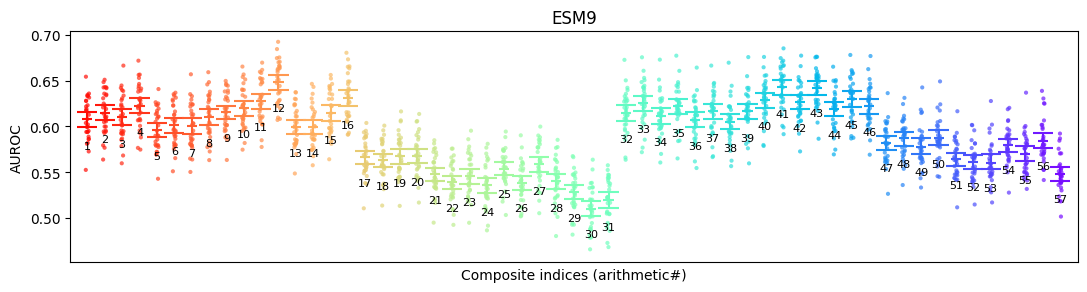

In [17]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.stripplot(
    data=df_auroc, 
    y="AUROC", x="", size=3, hue="", 
    ax=ax, 
    palette=[fixed_cmap[v] for v in metrics], alpha=.7
)

ax.set_xlim([-1, 57])
ax.set_ylim(np.array(ax.get_ylim()) + np.array([-.003, 0]))
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(df_auroc.loc[:, ""].unique(), rotation=90, ha="right")

xlim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax.get_xlim())))
        
for i, name in enumerate(metrics):
    ax.hlines(df_mean_auroc.loc[name], i - (xlim * .005), i + (xlim * .005), color=fixed_cmap[name])
    ax.hlines(aurocs_ci[name].low, i - (xlim * .01), i + (xlim * .01), color=fixed_cmap[name])
    ax.hlines(aurocs_ci[name].high, i - (xlim * .01), i + (xlim * .01), color=fixed_cmap[name])
    ax.vlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=fixed_cmap[name])
    ax.text(i, aurocs_ci[name].low - 0.015, f"{i + 1}", ha="center", va="top", size=8)

ax.tick_params(labelbottom=False, bottom=False)
# ax.spines["bottom"].set_visible(False)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

ax.set(title="ESM9", xlabel="Composite indices (arithmetic#)")


fig.savefig(f"{outputdir}/test9_roc_arithmetic.pdf", **kwarg_savefig)

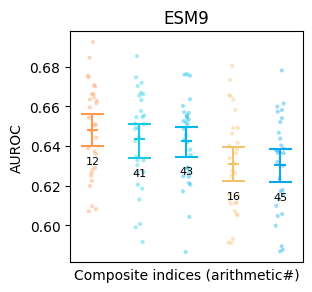

In [18]:
fig, ax = plt.subplots(figsize=(3, 3))

metrics = df_mean_auroc.sort_values("AUROC", ascending=False).index[:5].tolist()

df_temp = df_auroc.loc[
    np.sum([df_auroc.feat_names == m for m in metrics], axis=0).astype(bool), :
]

sns.stripplot(
    data=df_temp.loc[
        df_temp["feat_names"].apply(
            lambda name: {v: i for i, v in enumerate(metrics)}[name]
        ).sort_values().index, :
    ], 
    y="AUROC", x="", size=3, hue="", 
    ax=ax, 
    palette=[fixed_cmap[v] for v in metrics], alpha=.4
)

# ax.set_xlim([-1, 57])
# ax.set_ylim(np.array(ax.get_ylim()) + np.array([-.003, 0]))
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(df_auroc.loc[:, ""].unique(), rotation=90, ha="right")

xlim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax.get_xlim())))
        
for i, name in enumerate(metrics):
    ax.hlines(df_mean_auroc.loc[name], i - (xlim * .025), i + (xlim * .025), color=fixed_cmap[name])
    ax.hlines(aurocs_ci[name].low, i - (xlim * .05), i + (xlim * .05), color=fixed_cmap[name])
    ax.hlines(aurocs_ci[name].high, i - (xlim * .05), i + (xlim * .05), color=fixed_cmap[name])
    ax.vlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=fixed_cmap[name])
    ax.text(i, aurocs_ci[name].low - 0.005, f"{metrics[i].split('arithmetic')[-1]}", ha="center", va="top", size=8)

ax.tick_params(labelbottom=False, bottom=False)
# ax.spines["bottom"].set_visible(False)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

ax.set(title="ESM9", xlabel="Composite indices (arithmetic#)")


fig.savefig(f"{outputdir}/test9_auc_arithmetic.pdf", **kwarg_savefig)

In [19]:
np.arange(1, 58, 1)[
                np.argsort(
                    np.arange(57)[
                        np.argsort(df_mean_auroc.AUROC.values)
                    ][::-1]
                )
            ]

array([24, 18, 23, 10, 31, 27, 28, 22, 17, 13,  7,  1, 29, 30, 20,  4, 41,
       43, 40, 39, 48, 52, 50, 54, 47, 53, 46, 51, 55, 57, 56, 19,  9, 21,
       12, 25, 15, 26, 16,  6,  2,  8,  3, 14,  5, 11, 35, 33, 37, 32, 42,
       44, 45, 36, 38, 34, 49])

In [20]:
xs_roc, ys_roc = np.array([]), np.array([])
xs_pr, ys_pr = np.array([]), np.array([])
feat_names_roc, feat_names_pr = [], []
folds_roc, folds_pr = [], []

metrics = key_features + ["arithmetic12"]
aurocs = {key: [] for key in metrics}
aps = {key: [] for key in metrics}

for i, (_, te) in enumerate(
    StratifiedKFold(
        n_splits=30, shuffle=True, random_state=0
    ).split(df[metrics], df.better_with_pb)
):
    x_te, y_te = df[metrics].loc[te, :], df.better_with_pb[te]

    for key in metrics:
        x_roc, y_roc = roc_curve(y_te, x_te[key])[:2]
        x_pr, y_pr = precision_recall_curve(y_te, x_te[key])[:2][::-1]
        xs_roc, ys_roc = np.hstack([xs_roc, x_roc]), np.hstack([ys_roc, y_roc])
        xs_pr, ys_pr = np.hstack([xs_pr, x_pr]), np.hstack([ys_pr, y_pr])
        feat_names_roc += [key] * x_roc.size
        feat_names_pr += [key] * x_pr.size
        folds_roc += [i] * x_roc.size
        folds_pr += [i] * x_pr.size
        aurocs[key] += [roc_auc_score(y_te, x_te[key])]
        aps[key] += [average_precision_score(y_te, x_te[key])]


df_roc = pd.DataFrame({
    "x": xs_roc, "y": ys_roc, "feat_names": feat_names_roc, "folds": folds_roc
})
df_pr = pd.DataFrame({
    "x": xs_pr, "y": ys_pr, "feat_names": feat_names_pr, "folds": folds_pr
})

aurocs_ci = {
    k: bootstrap(
        (v,), **kwarg_bootstrap
    ).confidence_interval for k, v in aurocs.items()
}

aps_ci = {
    k: bootstrap(
        (v,), **kwarg_bootstrap
    ).confidence_interval for k, v in aps.items()
}

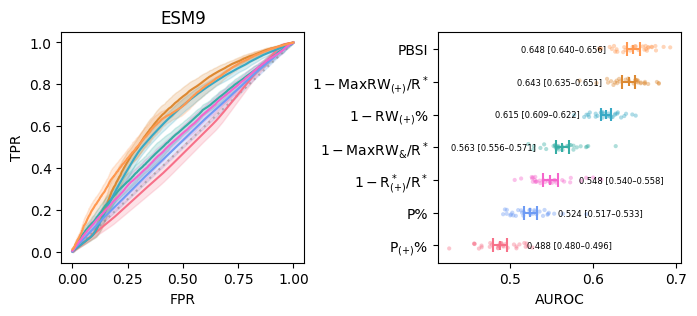

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.55)


df_roc_integrated = roc_multimetric_integration(df_roc)
fixed_cmap = {
    **fixed_cmap,
    **{
        k: c for k, c in zip(top10, sns.color_palette("husl", len(top10)))
    }
}

for i, key in enumerate(metrics):
    df_roc_sep = df_roc_integrated.loc[
        df_roc_integrated.feat_names == key, :
    ]
    ax[0].plot(
        df_roc_sep.x,
        df_roc_sep.iloc[:, 2:].mean(axis=1),
        c=fixed_cmap[key]
    )
    ax[0].fill_between(
        df_roc_sep.x, 
        df_roc_sep.iloc[:, 2:].mean(axis=1) - df_roc_sep.iloc[:, 2:].std(axis=1),
        df_roc_sep.iloc[:, 2:].mean(axis=1) + df_roc_sep.iloc[:, 2:].std(axis=1),
        color=fixed_cmap[key], alpha=.2, zorder=-(i + 1) * 10
    )

ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax[0].set(title="ESM9", xlabel="FPR", ylabel="TPR")
# ax.legend(fontsize="x-small", loc="lower right")

sorted_feat_names = pd.DataFrame(aurocs).mean().sort_values(ascending=False).index
sorted_cmap = pd.Series(
    metrics, index=metrics
)[sorted_feat_names].apply(lambda k: fixed_cmap[k]).tolist()

fmt_name = lambda name: "PBSI" if "arithmetic" in name else [
    feat_names_short[name], "$1-$" + feat_names_short[name]
][name in negs]

sorted_auroc = pd.DataFrame({
    "AUROC": np.array([aurocs[k] for k in sorted_feat_names]).ravel(),
    "feat_names": np.array([[k] * len(aurocs[k]) for k in sorted_feat_names]).ravel(),
    "": np.array([
        [fmt_name(k)] * len(aurocs[k]) for k in sorted_feat_names
    ]).ravel()
})

# fixed_cmap = {k: v for k, v in zip(sorted_feat_names, sorted_cmap)}

sns.stripplot(
    data=sorted_auroc, 
    x="AUROC", y="", size=3, hue="", 
    ax=ax[1], 
    palette=sorted_cmap, alpha=.4
)
# ax[1].set(xlim=(0, ax[1].get_xlim()[1]))


sorted_mean_auroc = sorted_auroc.loc[
    :, ["feat_names", "AUROC"]
].groupby("feat_names").mean().loc[sorted_feat_names]
        
ylim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax[1].get_ylim())))
        
for i, name in enumerate(sorted_feat_names):
    ax[1].vlines(sorted_mean_auroc.loc[name], i - (ylim * .02), i + (ylim * .02), color=sorted_cmap[i])
    ax[1].vlines(aurocs_ci[name].low, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax[1].vlines(aurocs_ci[name].high, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax[1].hlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=sorted_cmap[i])
    center = np.array(ax[1].get_xlim()).mean()
    is_larger = (sorted_mean_auroc.loc[name] > center).item()
    low, high = aurocs_ci[name].low, aurocs_ci[name].high
    ax[1].text(
        low - 0.025 if is_larger else high + 0.025,
        i, f"{f2s(sorted_mean_auroc.loc[name].item())} [{f2s(low)}–{f2s(high)}]",
        ha="right" if is_larger else "left", va="center", size=6
    )

# fig.savefig(f"{outputdir}/test9_roc", **kwarg_savefig)

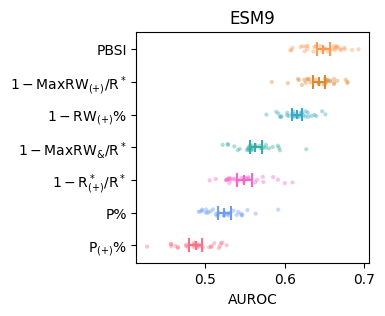

In [22]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.stripplot(
    data=sorted_auroc, 
    x="AUROC", y="", size=3, hue="", 
    ax=ax, 
    palette=sorted_cmap, alpha=.4
)
        
ylim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax.get_ylim())))
        
for i, name in enumerate(sorted_feat_names):
    ax.vlines(sorted_mean_auroc.loc[name], i - (ylim * .02), i + (ylim * .02), color=sorted_cmap[i])
    ax.vlines(aurocs_ci[name].low, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax.vlines(aurocs_ci[name].high, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax.hlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=sorted_cmap[i])
    # center = np.array(ax.get_xlim()).mean()
    # is_larger = (sorted_mean_auroc.loc[name] > center).item()
    # low, high = aurocs_ci[name].low, aurocs_ci[name].high
    # ax.text(
    #     low - 0.025 if is_larger else high + 0.025,
    #     i, f"{f2s(sorted_mean_auroc.loc[name].item())} [{f2s(low)}–{f2s(high)}]",
    #     ha="right" if is_larger else "left", va="center", size=6
    # )

ax.set(title="ESM9")

fig.savefig(f"{outputdir}/test9_roc_integrated.pdf", **kwarg_savefig)

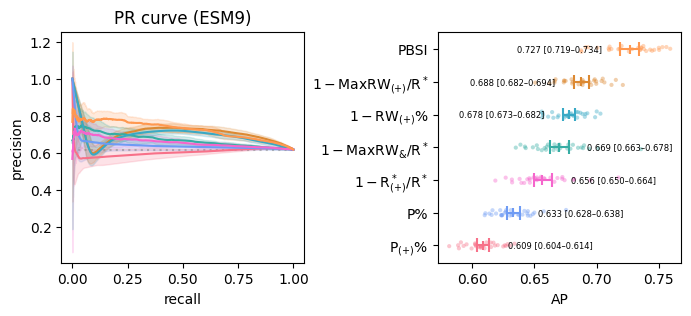

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.55)


df_pr_integrated = roc_multimetric_integration(df_pr)
# fixed_cmap = {
#     **fixed_cmap,
#     **{
#         k: c for k, c in zip(top10, sns.color_palette("husl", len(top10)))
#     }
# }

for i, key in enumerate(metrics):
    df_pr_sep = df_pr_integrated.loc[
        df_pr_integrated.feat_names == key, :
    ]
    ax[0].plot(
        df_pr_sep.x,
        df_pr_sep.iloc[:, 2:].mean(axis=1),
        c=fixed_cmap[key]
    )
    ax[0].fill_between(
        df_pr_sep.x, 
        df_pr_sep.iloc[:, 2:].mean(axis=1) - df_pr_sep.iloc[:, 2:].std(axis=1),
        df_pr_sep.iloc[:, 2:].mean(axis=1) + df_pr_sep.iloc[:, 2:].std(axis=1),
        color=fixed_cmap[key], alpha=.2, zorder=-(i + 1) * 10
    )

base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
ax[0].plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax[0].set(title="PR curve (ESM9)", xlabel="recall", ylabel="precision")
# ax.legend(fontsize="x-small", loc="lower right")

sorted_feat_names = pd.DataFrame(aps).mean().sort_values(ascending=False).index
sorted_cmap = pd.Series(
    metrics, index=metrics
)[sorted_feat_names].apply(lambda k: fixed_cmap[k]).tolist()

fmt_name = lambda name: "PBSI" if "arithmetic" in name else [
    feat_names_short[name], "$1-$" + feat_names_short[name]
][name in negs]

sorted_ap = pd.DataFrame({
    "AP": np.array([aps[k] for k in sorted_feat_names]).ravel(),
    "feat_names": np.array([[k] * len(aps[k]) for k in sorted_feat_names]).ravel(),
    "": np.array([
        [fmt_name(k)] * len(aps[k]) for k in sorted_feat_names
    ]).ravel()
})

# fixed_cmap = {k: v for k, v in zip(sorted_feat_names, sorted_cmap)}

sns.stripplot(
    data=sorted_ap, 
    x="AP", y="", size=3, hue="", 
    ax=ax[1], 
    palette=sorted_cmap, alpha=.4
)
# ax[1].set(xlim=(0, ax[1].get_xlim()[1]))


sorted_mean_ap = sorted_ap.loc[
    :, ["feat_names", "AP"]
].groupby("feat_names").mean().loc[sorted_feat_names]
        
ylim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax[1].get_ylim())))
        
for i, name in enumerate(sorted_feat_names):
    ax[1].vlines(sorted_mean_ap.loc[name], i - (ylim * .02), i + (ylim * .02), color=sorted_cmap[i])
    ax[1].vlines(aps_ci[name].low, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax[1].vlines(aps_ci[name].high, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax[1].hlines(i, aps_ci[name].low, aps_ci[name].high, color=sorted_cmap[i])
    center = np.array(ax[1].get_xlim()).mean()
    is_larger = (sorted_mean_ap.loc[name] > center).item()
    low, high = aps_ci[name].low, aps_ci[name].high
    ax[1].text(
        low - 0.015 if is_larger else high + 0.015,
        i, f"{f2s(sorted_mean_ap.loc[name].item())} [{f2s(low)}–{f2s(high)}]",
        ha="right" if is_larger else "left", va="center", size=6
    )

# fig.savefig(f"{outputdir}/test9_pr", **kwarg_savefig)

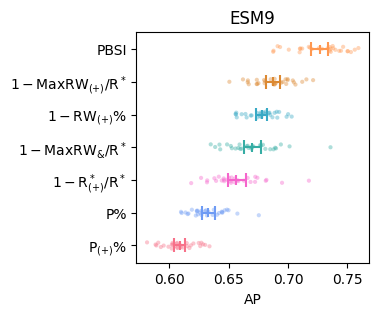

In [24]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.stripplot(
    data=sorted_ap, 
    x="AP", y="", size=3, hue="", 
    ax=ax, 
    palette=sorted_cmap, alpha=.4
)
        
ylim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax.get_ylim())))
        
for i, name in enumerate(sorted_feat_names):
    ax.vlines(sorted_mean_ap.loc[name], i - (ylim * .02), i + (ylim * .02), color=sorted_cmap[i])
    ax.vlines(aps_ci[name].low, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax.vlines(aps_ci[name].high, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax.hlines(i, aps_ci[name].low, aps_ci[name].high, color=sorted_cmap[i])
    # center = np.array(ax.get_xlim()).mean()
    # is_larger = (sorted_mean_ap.loc[name] > center).item()
    # low, high = aps_ci[name].low, aps_ci[name].high
    # ax.text(
    #     low - 0.015 if is_larger else high + 0.015,
    #     i, f"{f2s(sorted_mean_ap.loc[name].item())} [{f2s(low)}–{f2s(high)}]",
    #     ha="right" if is_larger else "left", va="center", size=6
    # )

ax.set(title="ESM9")

fig.savefig(f"{outputdir}/test9_pr_integrated.pdf", **kwarg_savefig)

[Text(0.5, 1.0, 'PR curve (ESM9)'),
 Text(0.5, 0, 'recall'),
 Text(0, 0.5, 'precision')]

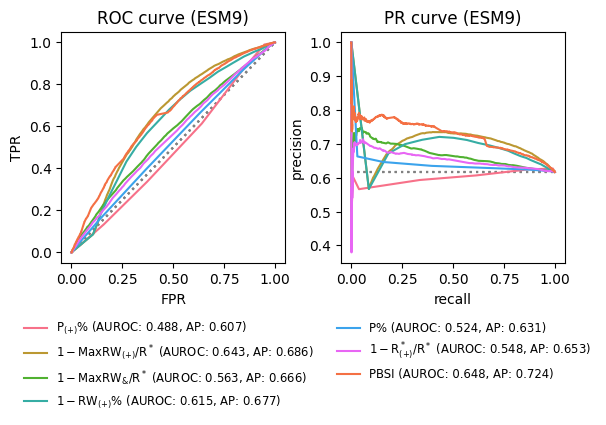

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))
plt.subplots_adjust(wspace=.25)

df_concat = pd.concat(
    [
        df_bar.loc[[v for v in df_bar.loc[key_features, :].index if v in key_features], :],
        df_bar_arith.iloc[:1, :]
    ],
    axis=0
)

features = [
    df.loc[:, v] for v in df_concat.index
]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else v for v in df_concat.index
]

names = [
    feat_names_short[v] if v in key_features else v for v in names
]

names = [
    "PBSI" if "arithmetic" in v else v for v in names
]


cmap = df_concat.cmap

for i, y in enumerate(features):
    ax[0].plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
    ax[1].plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + \
        f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)}, " + \
        f"AP: {average_precision_score(df.better_with_pb, y).round(3)})" , 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax[1].plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax[1].legend(fontsize="small", loc="upper center", bbox_to_anchor=(-.15, -.2), ncol=2, frameon=False)
ax[0].set(
    title="ROC curve (ESM9)", xlabel="FPR", ylabel="TPR"
)
ax[1].set(title="PR curve (ESM9)", xlabel="recall", ylabel="precision")

# fig.savefig(f"{outputdir}/test9_roc_pr_integrated", **kwarg_savefig)

[Text(0.5, 1.0, 'ESM9'),
 Text(0.5, 0, 'false positive rate'),
 Text(0, 0.5, 'true positive rate')]

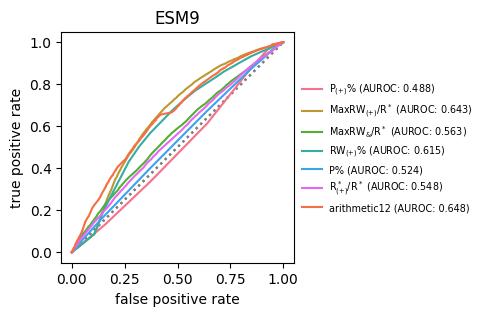

In [26]:
fig, ax = plt.subplots(figsize=(3, 3))

df_concat = pd.concat(
    [
        df_bar.loc[[v for v in df_bar.loc[key_features, :].index if v in key_features], :],
        df_bar_arith.iloc[:1, :]
    ],
    axis=0
)

features = [
    df.loc[:, v] for v in df_concat.index
]

names = [
    feat_names_short[v] if v in key_features else v for v in df_concat.index
]


cmap = df_concat.cmap

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), frameon=False)
ax.set(title="ESM9", xlabel="false positive rate", ylabel="true positive rate")

# fig.savefig(f"{outputdir}/test9_roc_integrated", **kwarg_savefig)

[Text(0.5, 1.0, 'ESM9'), Text(0.5, 0, 'recall'), Text(0, 0.5, 'precision')]

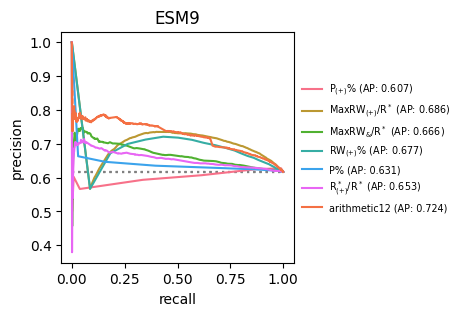

In [27]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax.plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), frameon=False)
ax.set(title="ESM9", xlabel="recall", ylabel="precision")

# fig.savefig(f"{outputdir}/test9_pr", **kwarg_savefig)

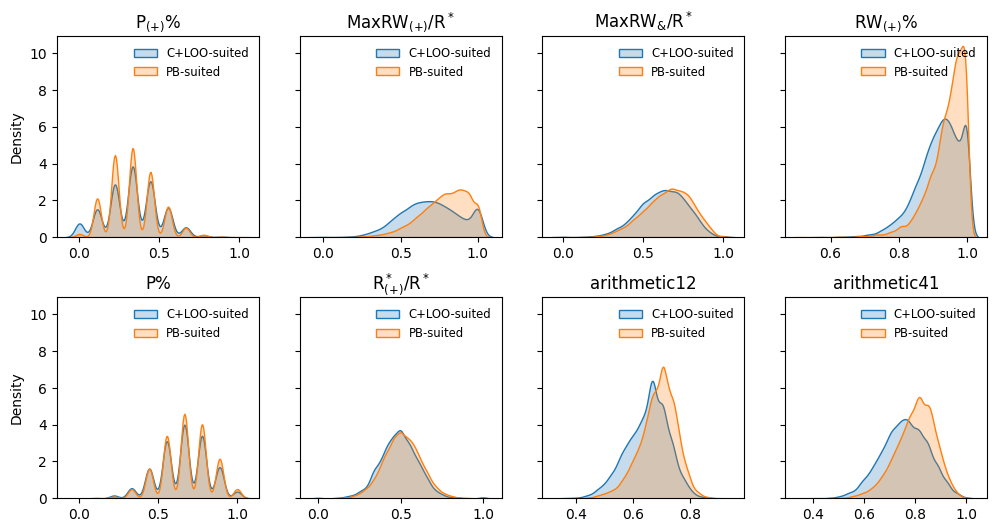

In [28]:
keys = np.array(key_features + ["arithmetic12", "arithmetic41"])

nrow = 2
ncol = np.ceil(keys.size / nrow).astype(int)

fig, ax = plt.subplots(
    nrow, ncol, 
    figsize=(3 * ncol, 3 * nrow), 
    sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for key, a in zip(keys, ax.ravel()):
    sns.kdeplot(df[key][df.better_with_pb == False], ax=a, label="C+LOO-suited", fill=True)
    sns.kdeplot(df[key][df.better_with_pb == True], ax=a, label="PB-suited", fill=True)
    a.legend(loc="upper right", fontsize="small", frameon=False)
    a.set(
        title=feat_names_short[key] if key in key_features else key, 
        xlabel=""
    )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/top10_kde{conf.suffix}", **kwarg_savefig)

from sklearn.metrics import r2_score

plt.plot(
    pd.concat([df.pb - df.cloo, df.iloc[:, 4:-1]], axis=1).corr().abs().iloc[:, 0].values
)

sns.heatmap(
    pd.concat(
        [df.pb - df.cloo, df.iloc[:, 4:-1]], axis=1
    ).corr().abs(),
    cmap="berlin"
)

In [29]:
pbsi_features = [
    'positive_pathway_coverage',
    'max_positive_edge_density',
    'mean_positive_edge_density',
]

In [30]:
xs, ys = np.array([]), np.array([])
feat_names = []
folds = []

metrics = pbsi_features
# metrics = top10

aurocs = {key: [] for key in ["Logistic regression", "PBSI"]}

for i, (tr, te) in enumerate(
    StratifiedKFold(
        n_splits=30, shuffle=True, random_state=0
    ).split(df[metrics], df.better_with_pb)
):
    x_tr, y_tr = df[metrics].loc[tr, :], df.better_with_pb[tr]
    x_te, y_te = df[metrics].loc[te, :], df.better_with_pb[te]

    for key in ["Logistic regression", "PBSI"]:
        if key == "Logistic regression":
            lr = LogisticRegression(random_state=0)
            lr.fit(x_tr, y_tr)
            x, y = roc_curve(y_te, lr.predict_proba(x_te)[:, 1])[:2]
            aurocs[key] += [roc_auc_score(y_te, lr.predict_proba(x_te)[:, 1])]
        else:
            x, y = roc_curve(y_te, df.loc[x_te.index, "arithmetic12"])[:2]
            aurocs[key] += [roc_auc_score(y_te, df.loc[x_te.index, "arithmetic12"])]

        xs, ys = np.hstack([xs, x]), np.hstack([ys, y])
        feat_names += [key] * x.size
        folds += [i] * x.size


df_roc = pd.DataFrame({
    "x": xs, "y": ys, "feat_names": feat_names, "folds": folds
})

aurocs_ci = {
    k: bootstrap(
        (v,), **kwarg_bootstrap
    ).confidence_interval for k, v in aurocs.items()
}

/tmp/ipykernel_56337/829231031.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(sorted_feat_names, fontsize="small")


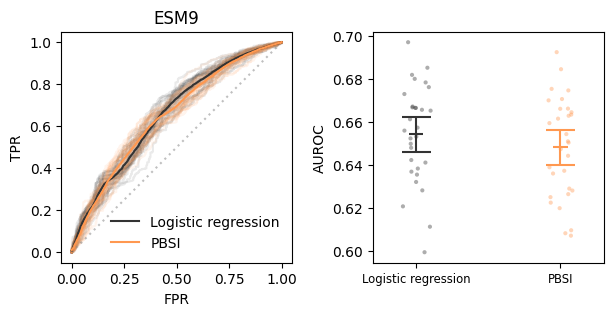

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(wspace=.35)

df_roc_integrated = roc_multimetric_integration(df_roc)
cmap = [".2", fixed_cmap["arithmetic12"]]

for i, key in enumerate(["Logistic regression", "PBSI"]):
    df_roc_sep = df_roc_integrated.loc[
        df_roc_integrated.feat_names == key, :
    ]
    
    for fold in df_roc.folds.unique():
        ax[0].plot(
            df_roc.loc[(df_roc.feat_names == key) & (df_roc.folds == fold), :].x,
            df_roc.loc[(df_roc.feat_names == key) & (df_roc.folds == fold), :].y,
            c=cmap[i], alpha=.1, zorder=-100
        )
    
    ax[0].plot(
        df_roc_sep.x,
        df_roc_sep.iloc[:, 2:].mean(axis=1),
        c=cmap[i], label=key, zorder=10
    )

ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax[0].set(title="ESM9", xlabel="FPR", ylabel="TPR")
ax[0].legend(loc="lower right", frameon=False)

sorted_feat_names = pd.DataFrame(aurocs).mean().sort_values(ascending=False).index
sorted_cmap = pd.Series(
    [i for i in range(len(["Logistic regression", "PBSI"]))], index=["Logistic regression", "PBSI"]
)[sorted_feat_names].apply(lambda i: cmap[i]).tolist()

# fmt_name = lambda name: "PBSI" if "arithmetic" in name else [
#     feat_names_short[name], "$1-$" + feat_names_short[name]
# ][name in negs]

sorted_auroc = pd.DataFrame({
    "AUROC": np.array([aurocs[k] for k in sorted_feat_names]).ravel(),
    "feat_names": np.array([[k] * len(aurocs[k]) for k in sorted_feat_names]).ravel(),
    "": np.array([
        [k] * len(aurocs[k]) for k in sorted_feat_names
    ]).ravel()
})

# fixed_cmap = {k: v for k, v in zip(sorted_feat_names, sorted_cmap)}

sns.stripplot(
    data=sorted_auroc, 
    y="AUROC", x="", size=3, hue="", 
    ax=ax[1], 
    palette=sorted_cmap, alpha=.4
)
# ax[1].set(xlim=(0, ax[1].get_xlim()[1]))


sorted_mean_auroc = sorted_auroc.loc[
    :, ["feat_names", "AUROC"]
].groupby("feat_names").mean().loc[sorted_feat_names]
        
xlim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax[1].get_xlim())))
ci_labels = []
        
for i, name in enumerate(sorted_feat_names):
    ax[1].hlines(sorted_mean_auroc.loc[name], i - (xlim * .025), i + (xlim * .025), color=sorted_cmap[i])
    ax[1].hlines(aurocs_ci[name].low, i - (xlim * .05), i + (xlim * .05), color=sorted_cmap[i])
    ax[1].hlines(aurocs_ci[name].high, i - (xlim * .05), i + (xlim * .05), color=sorted_cmap[i])
    ax[1].vlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=sorted_cmap[i])
#     low, high = aurocs_ci[name].low, aurocs_ci[name].high
#     ci_labels += [name + "\n" + f"{f2s(sorted_mean_auroc.loc[name].item())} [{f2s(low)}–{f2s(high)}]"]

ax[1].set_xticklabels(sorted_feat_names, fontsize="small")
ax[1].set_xlim([-.3, 1.3])

fig.savefig(f"{outputdir}/test9_logistic_regression.pdf", **kwarg_savefig)

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
def tp(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    return mat[1, 1] / mat[1].sum()

def fp(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    return mat[0, 1] / mat[0].sum()

In [34]:
vals = np.sort(df.arithmetic12.unique())

fps = np.vectorize(
    lambda t: fp(df.better_with_pb, df.arithmetic12 > t)
)(vals)

tps = np.vectorize(
    lambda t: tp(df.better_with_pb, df.arithmetic12 > t)
)(vals)

acc = np.vectorize(
    lambda t: accuracy_score(df.better_with_pb, df.arithmetic12 > t)
)(vals)

f1 = np.vectorize(
    lambda t: f1_score(df.better_with_pb, df.arithmetic12 > t)
)(vals)

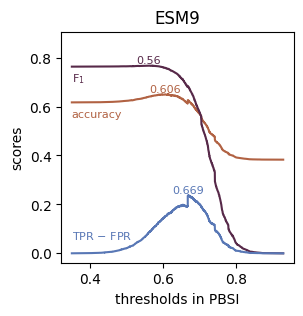

In [35]:
fig, ax = plt.subplots(figsize=(3, 3))

# thresh = np.linspace(0, 1, 21)
df_thresh = pd.DataFrame({
    "thresh": vals,
    "accuracy": acc,
    "F$_1$": f1,
    "TPR $-$ FPR": tps - fps,
})


metrics = np.array(["accuracy", "F$_1$", "TPR $-$ FPR"])
thresh_recorder = {}
cmap = [
    plt.cm.managua(
        (i + 1) / (metrics.size + 1)
    ) for i in range(metrics.size)
]

for i, key in enumerate(metrics):
    v = df_thresh.loc[:, key].values
    argmax = np.argmax(v)

    sns.lineplot(
        data=df_thresh, x="thresh", y=key, 
        label=f"{key} (argmax: {vals[argmax].round(3)})",
        c=cmap[i]
    )
    ax.text(
        vals[argmax], v[argmax], vals[argmax].round(3),
        ha="center", va="bottom", c=cmap[i], size=8
    )
    ax.text(
        vals[0], v[0], 
        key + "\n" if v[0] < .5 else "\n\n" + key, 
        ha="left", 
        va="bottom" if v[0] < .5 else "center", c=cmap[i],
        size=8
    )
    thresh_recorder = {**thresh_recorder, key: vals[argmax]}
    

ax.set(
    title="ESM9",
    xlabel="thresholds in PBSI", ylabel="scores",
    ylim = np.array(ax.get_ylim()) + np.array([0, .1])
)
# ax.legend(fontsize="x-small")
ax.legend().remove()


fig.savefig(f"{outputdir}/test9_thresholds.pdf", **kwarg_savefig)

In [36]:
from doe_modules.simulation import model_phi, model_psi

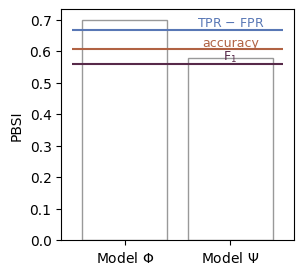

In [37]:
fig, ax= plt.subplots(figsize=(3, 3))

sns.barplot(
    data=pd.DataFrame({
        "": ["Model $\Phi$", "Model $\Psi$"],
        "PBSI": map(pbsi, [model_phi, model_psi])
    }),
    x="", y="PBSI", ax=ax, color="w", edgecolor=".6"
)

xlim = ax.get_xlim()

for i, (k, v) in enumerate(thresh_recorder.items()):
    c = [
        plt.cm.managua(
            (i + 1) / (metrics.size + 1)
        ) for i in range(metrics.size)
    ]
    ax.hlines(v, *xlim, color=c[i], label=k)
    ax.text(1, v, k, size=9, ha="center", va="bottom", color=c[i])
    
# ax.legend(loc="lower right", fontsize="small")

fig.savefig(f"{outputdir}/test9_simulators.pdf", **kwarg_savefig)

In [38]:
## sparse regulations
p1_arr = np.array([
    1, 1, 1, 1, 1, 1, 1, 1, 1,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0,
    0, 0, 0,
    0, 0,
    0
])

## the most C+LOO-suited
c_arr = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 1,
    1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1,
    1, 1, 1, 1,
    1, 1, 1,
    1, 1,
    1
])

## the most PB-suited
p2_arr = np.array([
    1, 1, 1, 1, 1, 1, 1, 1, 1,
    -1, -1, -1, -1, -1, -1, -1, -1,
    -1, -1, -1, -1, -1, -1, -1,
    -1, -1, -1, -1, -1, -1,
    -1, -1, -1, -1, -1,
    -1, -1, -1, -1,
    -1, -1, -1,
    -1, -1,
    -1
])

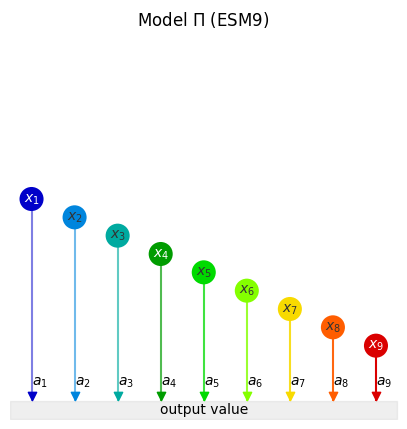

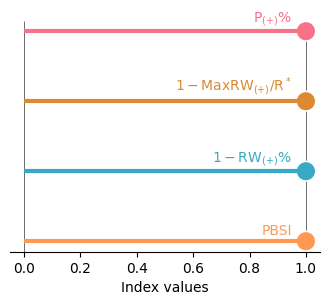

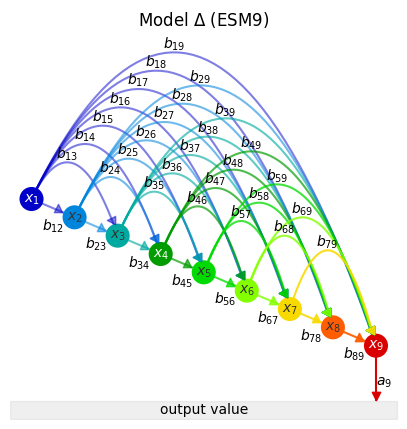

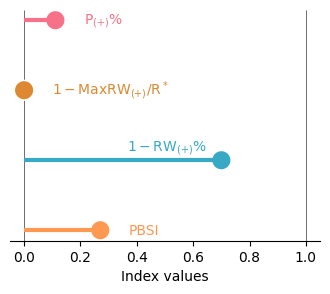

In [81]:
for k, model_arr in {"p": p1_arr, "c": c_arr}.items():

    fig, ax = plt.subplots(figsize=(5, 5))

    esm9 = Test9(edge_assignment=model_arr)

    esm9.plot(ax=ax)

    ax.set_title(
        ["Model $\Pi$ (ESM9)", "Model $\Delta$ (ESM9)", "Model P2 (ESM9)"][model_arr[9:].mean().astype(int)]
    )
    
    fig.savefig(f"{outputdir}/sim_model_{k}.pdf", **kwarg_savefig)
    
    
    fig, ax = plt.subplots(figsize=(4, 3))

    df_network_metrics = pd.DataFrame({
        "scores": [
            positive_pathway_coverage(model_arr), 
            1 - max_positive_edge_density(model_arr),
            1 - mean_positive_edge_density(model_arr),
            pbsi(model_arr)
        ],
        "": [
            "$1-$" + feat_names_short[k] if k in negs else feat_names_short[k] for k in pbsi_features
        ] + ["PBSI"]
    })

    sns.scatterplot(
        data=df_network_metrics,
        y="", x="scores", palette=[fixed_cmap[k] for k in pbsi_features] + [fixed_cmap["arithmetic12"]],
        hue="", legend=False, s=200
    )
    
    for i, c in enumerate([fixed_cmap[k] for k in pbsi_features] + [fixed_cmap["arithmetic12"]]):
        score = df_network_metrics.scores[i]
        ax.hlines(i, 0, score, color=c, lw=3)
        ax.text(
            score -.05 if score > .5 else score + 0.1,
            i - 0.05 if score > .5 else i,
            df_network_metrics[""][i], c=c, 
            ha="right" if score > .5 else "left", 
            va="bottom" if score > .5 else "center"
        )
    
    ylim = ax.get_ylim()
    ax.vlines(0, *ylim, color=".2", lw=.5, zorder=-10)
    ax.vlines(1, *ylim, color=".2", lw=.5, zorder=-10)
    
    [ax.spines[loc].set_visible(False) for loc in ["top", "right", "left"]]
    ax.tick_params(labelleft=False, left=False)

    ax.set(xlim=(-.05, 1.05), ylim=ylim, xlabel="Index values")
    
    fig.savefig(f"{outputdir}/sim_model_{k}_indices.pdf", **kwarg_savefig)

In [84]:
pipe = BenchmarkingPipeline(
    configuration={
        "p": {"edge_assignment": p1_arr, "model_id": "Model $\Pi$"},
        "c": {"edge_assignment": c_arr, "model_id": "Model $\Delta$"}
    },
    simulator=Test9,
    noise_arr=[.5, 1, 2, 4],
    n_range=np.arange(1, 11),
    n_rep=30
)

Running benchmarking pipeline:   0%|          | 0/2 [00:00<?, ?it/s]

generating simulated results with experimental designs:   0%|          | 0/2 [00:00<?, ?it/s]

encoding simulated results with MLR/AVOVA:   0%|          | 0/2 [00:00<?, ?it/s]

evaluating experimental design performance:   0%|          | 0/2 [00:00<?, ?it/s]

pb-based simulators:   0%|          | 0/1200 [00:00<?, ?it/s]

cloo-based simulators:   0%|          | 0/1200 [00:00<?, ?it/s]

power analysis:   0%|          | 0/2 [00:00<?, ?it/s]

generating simulated results with experimental designs:   0%|          | 0/2 [00:00<?, ?it/s]

encoding simulated results with MLR/AVOVA:   0%|          | 0/2 [00:00<?, ?it/s]

evaluating experimental design performance:   0%|          | 0/2 [00:00<?, ?it/s]

pb-based simulators:   0%|          | 0/1200 [00:00<?, ?it/s]

cloo-based simulators:   0%|          | 0/1200 [00:00<?, ?it/s]

power analysis:   0%|          | 0/2 [00:00<?, ?it/s]

Plotting:   0%|          | 0/3 [00:00<?, ?it/s]

plot_groundtruth:   0%|          | 0/2 [00:00<?, ?it/s]

plot_benchmarking:   0%|          | 0/2 [00:00<?, ?it/s]

plot_power:   0%|          | 0/2 [00:00<?, ?it/s]

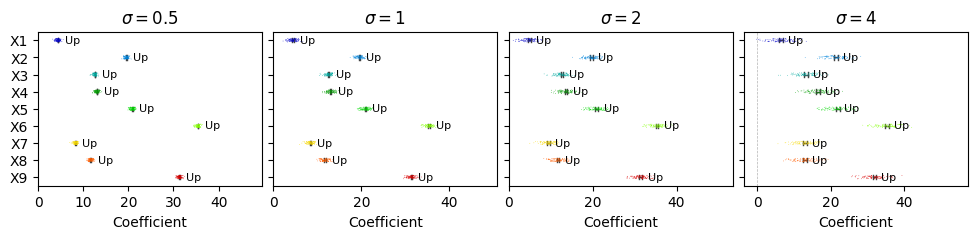

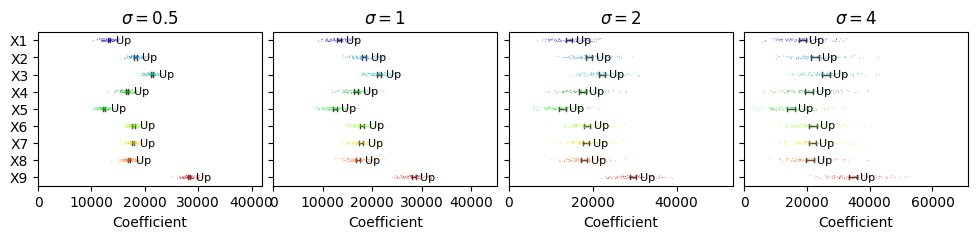

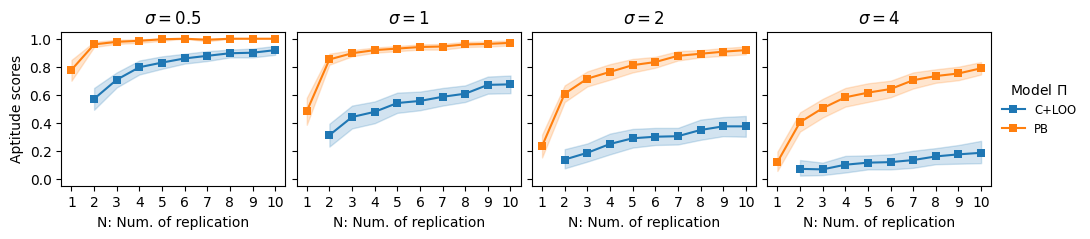

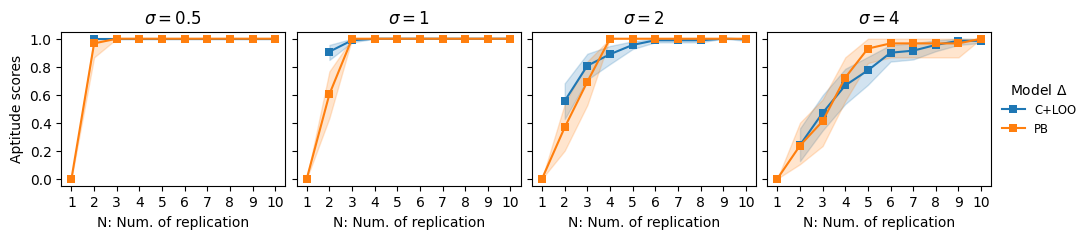

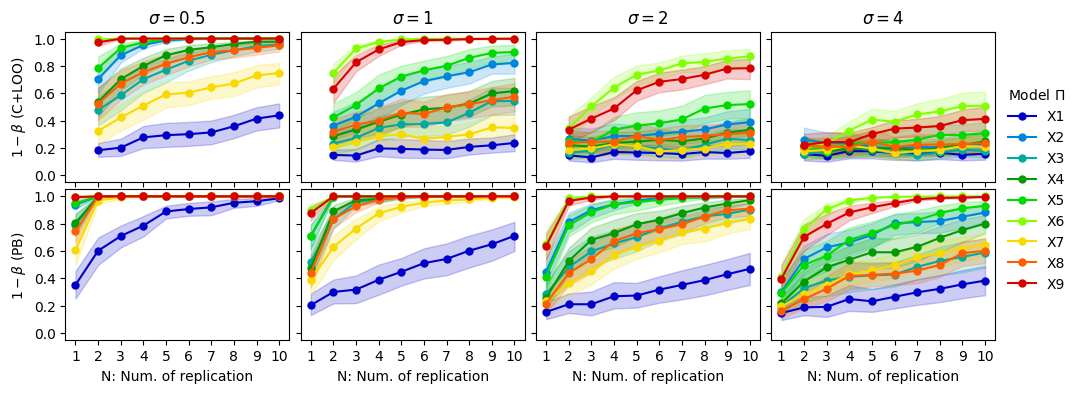

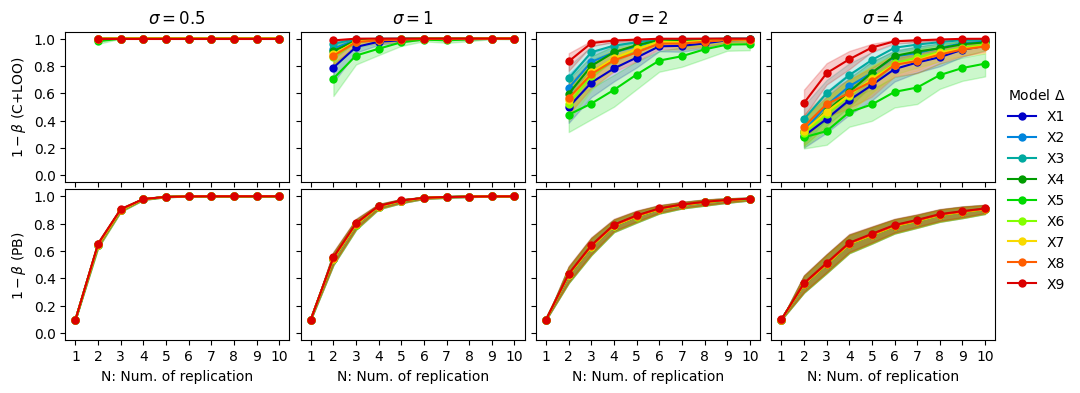

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



In [86]:
pipe.plot(savefig=True, extension=".pdf")